In [1]:
import sys
sys.path.append("..")
from plot_utils import *
from BTwins.utils import calc_lambda

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.distributions import Beta
from torch.distributions.dirichlet import Dirichlet
from tqdm import tqdm
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
#
from utils import *
from functions import *

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, d_in, d_out, batch_norm):
        super().__init__()
        if batch_norm:
            self.ff = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.BatchNorm1d(d_out),
                nn.ReLU(inplace=True)
            )
        else:
            self.ff = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.ff(x)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
class Net(nn.Module):
    def __init__(self, d_in, d_hid, n_hid, d_out, batch_norm=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.n_hid = n_hid
        self.d_hid = d_hid
        
        self.dims = [d_in] + [d_hid] * n_hid
        self.bn = nn.BatchNorm1d(d_out,affine=False)
        layers = []
        for idx in range(len(self.dims) - 1):
            layers.append(BasicBlock(self.dims[idx], self.dims[idx + 1], batch_norm))
        layers.append(nn.Linear(self.dims[-1], d_out))
        layers.append(nn.Sigmoid())
        self.backbone = nn.Sequential(*layers)
    def forward(self, x):
        return self.backbone(x)

class GMDist():
    def __init__(self, mus, stds, alphas):
        assert mus.shape == stds.shape
        assert alphas.sum() == 1
        if len(mus.shape) == 1:
            mus = mus.reshape((1, -1))
            stds = sts.reshape((1, -1))
        assert mus.shape[0] == len(alphas)
        self.mus = mus
        self.stds = stds
        self.alphas = alphas
        #
        self.dist_cat = torch.distributions.Categorical(alphas)
    
    def sample(self, n, shuffle=True):
        y = self.dist_cat.sample((n,))
        n_subsamples = torch.bincount(y)
        y = y.sort()[0]
        x = []
        for idx, n_sub in enumerate(n_subsamples):
            x.append(torch.distributions.Normal(self.mus[idx], self.stds[idx]).sample((n_sub,)))
        x = torch.cat(x)
        if shuffle:
            idcs = torch.randperm(x.size()[0]) 
            x = x[idcs]
            y = y[idcs]
        return x, y
    
    def sample_barlow(self, n, shuffle=True):
        y = self.dist_cat.sample((n,))
        n_subsamples = torch.bincount(y)
        y = y.sort()[0]
        x1 = []
        x2 = []
        for idx, n_sub in enumerate(n_subsamples):
            x1.append(torch.distributions.Normal(self.mus[idx], self.stds[idx]).sample((n_sub,)))
            x2.append(torch.distributions.Normal(self.mus[idx], self.stds[idx]).sample((n_sub,)))
        x1 = torch.cat(x1)
        x2 = torch.cat(x2)
        if shuffle:
            idcs = torch.randperm(x1.size()[0]) 
            x1 = x1[idcs]
            x2 = x2[idcs]
            y = y[idcs]
        return (x1, x2), y

def get_normalizer(x):
    norm_mean = x.mean(axis=0)
    norm_std = (x - norm_mean).std(axis=0)
    #
    def normalize(samples):
        return (samples - norm_mean) / norm_std
    return normalize

def normalize_z(z, eps):
    return (z - z.mean(axis=0)) / (torch.sqrt(z.var(axis=0)) + eps)

In [4]:
for d in [2, 4, 8, 16, 32, 64, 128, 512]:
    lmbda = calc_lambda(d)
    g = d / ((d**2 - d) * lmbda)
    h = ((d**2 - d) * lmbda) / d
    print("{:>4d}: {:8.4f} on/off={:.4f} off/on={:8.4f}".format(d,lmbda, g, h))

   2:  40.9836 on/off=0.0244 off/on= 40.9836
   4:  13.6612 on/off=0.0244 off/on= 40.9836
   8:   5.8548 on/off=0.0244 off/on= 40.9836
  16:   2.7322 on/off=0.0244 off/on= 40.9836
  32:   1.3221 on/off=0.0244 off/on= 40.9836
  64:   0.6505 on/off=0.0244 off/on= 40.9836
 128:   0.3227 on/off=0.0244 off/on= 40.9836
 512:   0.0802 on/off=0.0244 off/on= 40.9836


# GMM

tensor([0.0358, 0.6829]) tensor([2.6923, 1.6325])
tensor([1.9073e-08, 8.5831e-09]) tensor([1.0000, 1.0000])


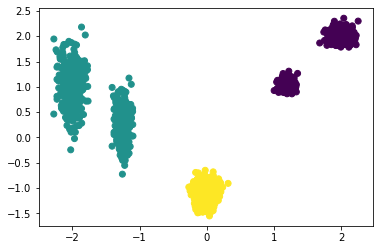

In [5]:
mus = torch.Tensor([
    [2, 2],
    [-2,1],
    [0, -1]
])
stds = torch.Tensor([
    [0.1, 0.1],
    [0.1, 0.4],
    [0.1, 0.1]
])
alphas = torch.Tensor([1/3, 1/3, 1/3])
dist_in = GMDist(mus, stds, alphas)
#
n_samples = 1000
x,y = dist_in.sample(n_samples)
#
normalizer = get_normalizer(x)
x_normalized = normalizer(x)
#
plt.scatter(x[:,0], x[:,1], c=y)
plt.scatter(x_normalized[:,0], x_normalized[:, 1],c=y)
#
print(x.mean(axis=0), x.var(axis=0))
print(x_normalized.mean(axis=0), x_normalized.var(axis=0))

In [6]:
y.shape

torch.Size([1000])

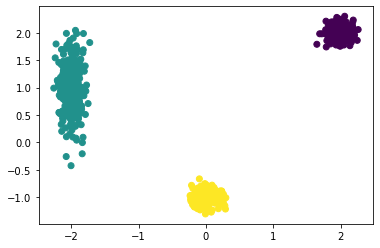

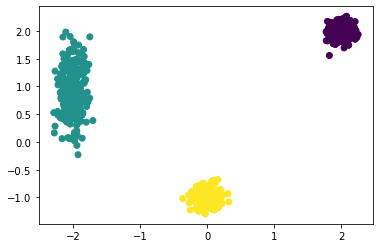

In [7]:
(x1, x2), y = dist_in.sample_barlow(n_samples)
plt.scatter(x1[:,0], x1[:,1], c=y)
plt.show()
#
plt.scatter(x2[:,0], x2[:,1], c=y)

# Beta Twins

tensor([0.5210, 1.5844]) tensor([2.5773, 4.0044])
tensor([ 0.0223, -0.0036]) tensor([0.9854, 1.0086])


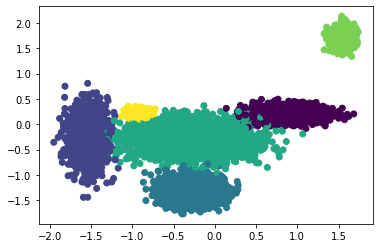

In [8]:
# INPUT DATA
mus = torch.Tensor([
    [2, 2],
    [-2,1],
    [0, -1],
    [0, 1],
    [3, 5],
    [-1, 2],
])
stds = torch.Tensor([
    [0.4, 0.2],
    [0.2, 0.7],
    [0.3, 0.3],
    [0.6, 0.4],
    [0.1, 0.2],
    [0.1, 0.1],
])
alphas = torch.Tensor([0.1, 0.1, 0.2, 0.3, 0.2, 0.1])
dist_in = GMDist(mus, stds, alphas)
#
x,y = dist_in.sample(10000)
normalizer = get_normalizer(x)

x,y = dist_in.sample(10000)
xt = normalizer(x)
#
print(x.mean(axis=0), x.var(axis=0))
print(xt.mean(axis=0), xt.var(axis=0))
#
plt.scatter(xt[:,0], xt[:,1], c=y)

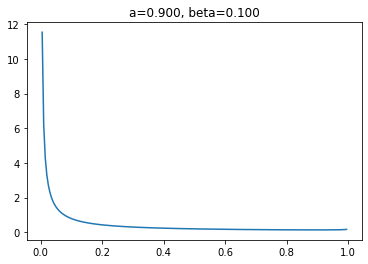

In [9]:
# MODEL SPEC
d_in = mus.shape[1]
d_hid = 32
d_out = 6
n_hid = 5
batch_norm = True

# BETA LOSS
a_true, b_true = torch.Tensor([0.1, 0.9])
dist_true = Beta(a_true, b_true)

# TRAIN SPEC
batch_size = 512
num_steps = 600
num_epochs = 5
plot_freq = 5

dist_true = Beta(a_true, b_true)
plot_beta_pdf(dist_true, "True")

### Test Pipeline

LR(X) 0.987
LR(Z) 0.302


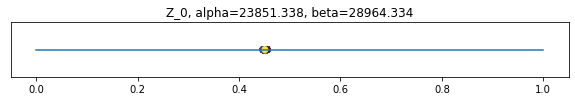

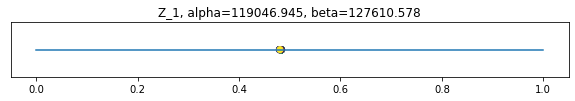

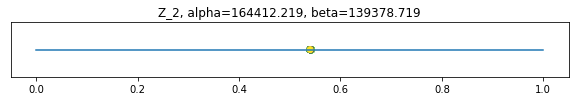

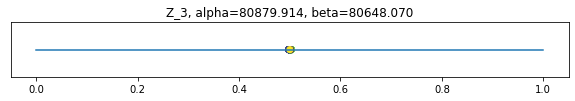

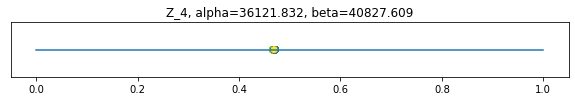

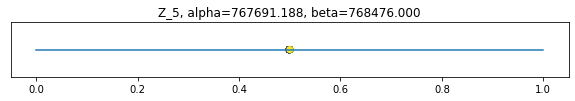

In [10]:
x_train,y_train = dist_in.sample(1000)
x_valid,y_valid = dist_in.sample(1000)
#
x_train = normalizer(x_train)
x_valid = normalizer(x_valid)
#
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print("LR(X)", clf.score(x_valid, y_valid))
#
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
model.eval()
with torch.no_grad():
    z_train = model(x_train)
    z_valid = model(x_valid)

clf = LogisticRegression(random_state=0).fit(z_train, y_train)
print("LR(Z)", clf.score(z_valid, y_valid))
#
a_z, b_z = beta_params(z_train)
for idx in range(d_out):
    title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
    simplex_plot(z_train[:,idx].detach().numpy(), title=title, c=y_train)

### TRAIN

Epoch [  1/  5] train:██████████600/600 [, loss=0.00567, a_min=0.098, a_max=0.106, b_min=0.844, b_max=0.963]  
Epoch [  2/  5] train:██████████600/600 [, loss=0.00901, a_min=0.0978, a_max=0.107, b_min=0.822, b_max=0.945] 
Epoch [  3/  5] train:██████████600/600 [, loss=0.00388, a_min=0.0961, a_max=0.102, b_min=0.794, b_max=0.893] 
Epoch [  4/  5] train:██████████600/600 [, loss=0.00288, a_min=0.0961, a_max=0.102, b_min=0.833, b_max=0.966] 
Epoch [  5/  5] train:██████████600/600 [, loss=0.00343, a_min=0.0968, a_max=0.102, b_min=0.794, b_max=0.91]  


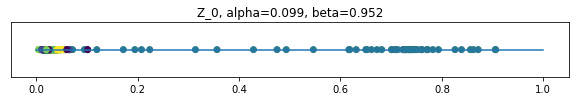

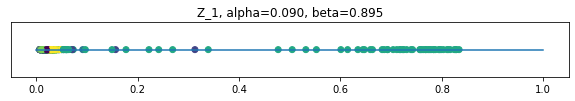

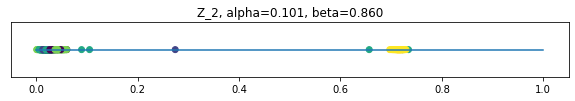

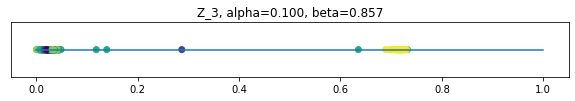

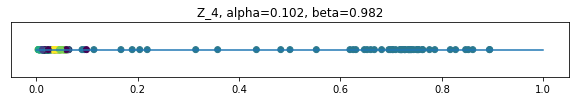

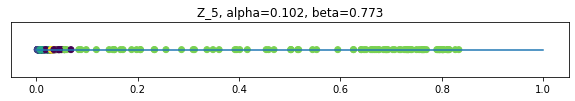

   LINPROB: 0.660


In [11]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    model.train()
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, num_epochs, 'train')
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{n_fmt}/{total_fmt} [{postfix}]')
    epoch_loss = 0
    for step in pbar:
        x, y = dist_in.sample(batch_size)
        x = normalizer(x)
        # ##########
        # TRAIN
        # ##########
        for param in model.parameters():
            param.grad = None
        z = model(x)
        a_z, b_z = beta_params(z)
        loss =  kl_beta_beta((a_z,b_z),(a_true,b_true),forward=True).sum()
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item(),
                          'a_min': a_z.min().item(),
                          'a_max': a_z.max().item(),
                          'b_min': b_z.min().item(),
                          'b_max': b_z.max().item()
                         }
                        )
        
    all_loss.append(epoch_loss / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x, y = dist_in.sample(batch_size)
            x = normalizer(x)
            z = model(x)
            a_z, b_z = beta_params(z)
            #
            for idx in range(d_out):
                title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
                simplex_plot(z[:,idx].detach().numpy(), title=title, c=y)
            
            x_train,y_train = dist_in.sample(1000)
            x_valid, y_valid = dist_in.sample(100)
            #
            x_train = normalizer(x_train)
            x_valid = normalizer(x_valid)
            #
            z_train = model(x_train)
            z_valid = model(x_valid)
            #
            clf = LogisticRegression(random_state=0).fit(z_train, y_train)
            print("   LINPROB: {:.3f}".format(clf.score(z_valid, y_valid)))

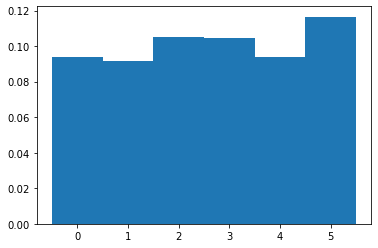

<BarContainer object of 512 artists>

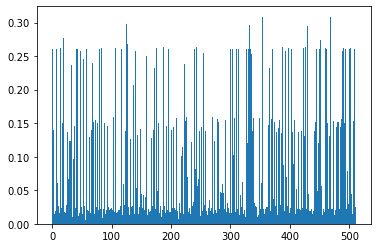

In [12]:
plt.bar(range(d_out), z.mean(axis=0), width=1.0)
plt.show()
plt.bar(range(z.shape[0]), z.mean(axis=1), width=1.0)

# Barlow Twins

tensor([0.5155, 1.5936]) tensor([2.6072, 3.9927])
tensor([ 0.0068, -0.0099]) tensor([0.9943, 0.9958])


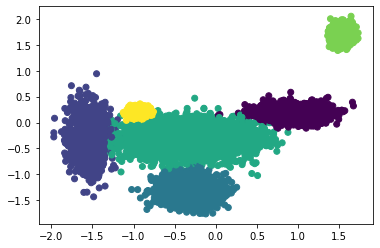

In [13]:
# INPUT DATA
mus = torch.Tensor([
    [2, 2],
    [-2,1],
    [0, -1],
    [0, 1],
    [3, 5],
    [-1, 2],
])
stds = torch.Tensor([
    [0.4, 0.2],
    [0.2, 0.7],
    [0.3, 0.3],
    [0.6, 0.4],
    [0.1, 0.2],
    [0.1, 0.1],
])
alphas = torch.Tensor([0.1, 0.1, 0.2, 0.3, 0.2, 0.1])
dist_in = GMDist(mus, stds, alphas)
#
x,y = dist_in.sample(10000)
normalizer = get_normalizer(x)

x,y = dist_in.sample(10000)
xt = normalizer(x)
#
print(x.mean(axis=0), x.var(axis=0))
print(xt.mean(axis=0), xt.var(axis=0))
#
plt.scatter(xt[:,0], xt[:,1], c=y)

In [14]:
# MODEL
d_in = mus.shape[1]
d_hid = 32
d_out = 4
n_hid = 5
batch_norm = True

# BARLOW LOSS
w_off = 41                  # used with mean
lmbda = calc_lambda(d_out)  # used with sum
eps = 1e-8

# TRAIN SPEC
batch_size = 512
num_steps = 400
num_epochs = 10
plot_freq = 10
#
print("LAMBDA: {:.4f}".format(lmbda))

LAMBDA: 13.6612


### Test Pipeline

LR(X) 0.987
LR(Z) 0.324


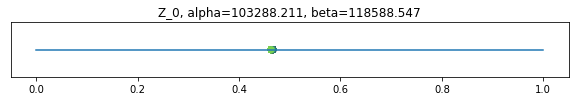

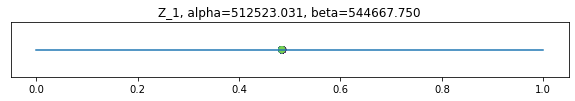

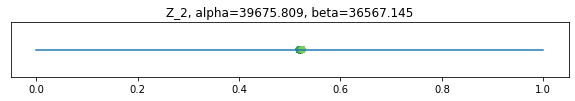

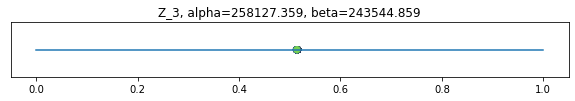

In [15]:
x_train,y_train = dist_in.sample(1000)
x_valid,y_valid = dist_in.sample(1000)
#
x_train = normalizer(x_train)
x_valid = normalizer(x_valid)
#
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print("LR(X)",clf.score(x_valid, y_valid))
#
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
model.eval()
with torch.no_grad():
    z_train = model(x_train)
    z_valid = model(x_valid)

clf = LogisticRegression(random_state=0).fit(z_train, y_train)
print("LR(Z)", clf.score(z_valid, y_valid))
#
a_z, b_z = beta_params(z_train)
for idx in range(d_out):
    title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
    simplex_plot(z_train[:,idx].detach().numpy(), title=title, c=y_train)

Epoch [  1/ 10] train:██████████400/400 [, loss=0.00479, l_on=0.0035, l_off=0.00129]  
Epoch [  2/ 10] train:██████████400/400 [, loss=0.00664, l_on=0.00377, l_off=0.00287] 
Epoch [  3/ 10] train:██████████400/400 [, loss=0.00279, l_on=0.00147, l_off=0.00131]  
Epoch [  4/ 10] train:██████████400/400 [, loss=0.00167, l_on=0.000939, l_off=0.000734]
Epoch [  5/ 10] train:██████████400/400 [, loss=0.0024, l_on=0.00158, l_off=0.000822]  
Epoch [  6/ 10] train:██████████400/400 [, loss=0.00204, l_on=0.00139, l_off=0.000657]  
Epoch [  7/ 10] train:██████████400/400 [, loss=0.00134, l_on=0.000929, l_off=0.000414] 
Epoch [  8/ 10] train:██████████400/400 [, loss=0.00163, l_on=0.000801, l_off=0.000826] 
Epoch [  9/ 10] train:██████████400/400 [, loss=0.00197, l_on=0.000599, l_off=0.00137]  
Epoch [ 10/ 10] train:██████████400/400 [, loss=0.00292, l_on=0.00208, l_off=0.00084]   


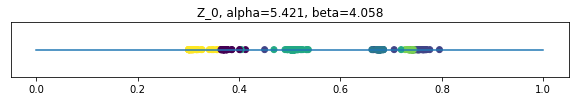

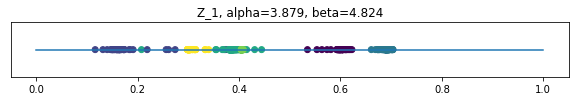

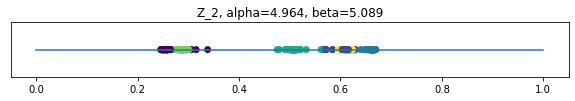

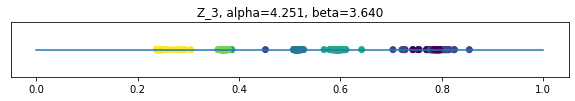

   LINPROB: 1.000


In [16]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    # ##########
    # TRAIN
    # ##########
    model.train()
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, num_epochs, 'train')
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{n_fmt}/{total_fmt} [{postfix}]')
    epoch_loss = 0
    for step in pbar:
        (x1, x2), _ = dist_in.sample_barlow(batch_size)
        x1 = normalizer(x1)
        x2 = normalizer(x2)
        for param in model.parameters():
            param.grad = None
        z1 = model(x1)
        z2 = model(x2)
        # BatchNorm normalization
        #c = model.bn(z1).T @ model.bn(z2)
        #c.div_(z1.shape[0])
        #
        z1_norm = normalize_z(z1, eps)
        z2_norm = normalize_z(z2, eps)
        #
        c = z1_norm.T @ z2_norm
        c.div_(z1.shape[0])
        
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        #
        loss = on_diag + off_diag
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item(),
                          'l_on': on_diag.item(),
                          'l_off': off_diag.item(),
                         }
                        )
        
    all_loss.append(epoch_loss / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x, y = dist_in.sample(batch_size)
            x = normalizer(x)
            z = model(x)
            a_z, b_z = beta_params(z)
            #
            for idx in range(d_out):
                title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
                simplex_plot(z[:,idx].detach().numpy(), title=title, c=y)
            
            x_train,y_train = dist_in.sample(1000)
            x_valid, y_valid = dist_in.sample(100)
            #
            x_train = normalizer(x_train)
            x_valid = normalizer(x_valid)
            #
            z_train = model(x_train)
            z_valid = model(x_valid)
            #
            clf = LogisticRegression(random_state=0).fit(z_train, y_train)
            print("   LINPROB: {:.3f}".format(clf.score(z_valid, y_valid)))

In [17]:
(x1, x2), y = dist_in.sample_barlow(5000)
x1 = normalizer(x1)
x2 = normalizer(x2)
with torch.no_grad():
    z1 = model(x1)
    z2 = model(x2)

In [18]:
z1_norm = normalize_z(z1, eps)
z2_norm = normalize_z(z2, eps)

In [19]:
clf = LogisticRegression(random_state=0).fit(z1, y)
print("   LINPROB: {:.3f}".format(clf.score(z2, y)))

   LINPROB: 0.993


In [20]:
c = z1_norm.T @ z2_norm
c.div_(z1.shape[0])
c

tensor([[ 0.9874,  0.0079, -0.0204, -0.0158],
        [ 0.0075,  0.9872,  0.0512, -0.0288],
        [-0.0204,  0.0501,  0.9909,  0.0493],
        [-0.0143, -0.0291,  0.0482,  0.9865]])

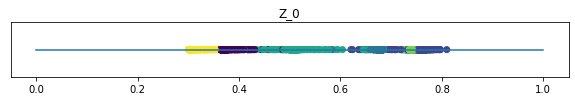

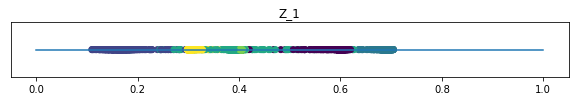

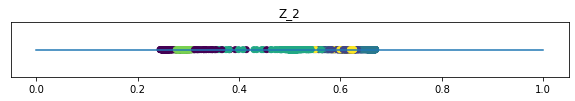

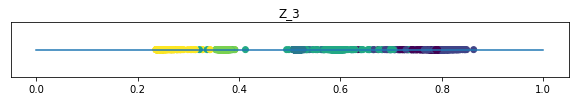

In [21]:
for idx in range(d_out):
    title = "Z_{}".format(idx)
    simplex_plot(z1[:,idx].detach().numpy(), title=title, c=y)

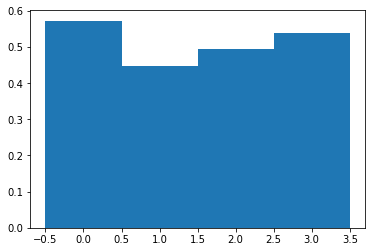

<BarContainer object of 512 artists>

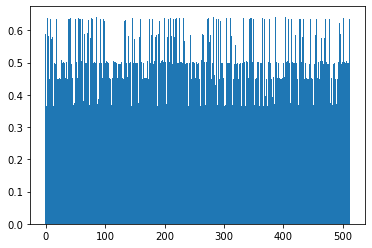

In [22]:
plt.bar(range(d_out), z.mean(axis=0), width=1.0)
plt.show()
plt.bar(range(z.shape[0]), z.mean(axis=1), width=1.0)

# Beta-Barlow Twins

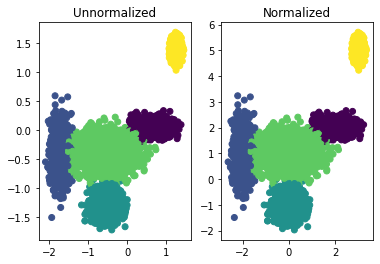

tensor([0.9061, 1.9167]) tensor([2.8719, 5.0308])
tensor([0.0044, 0.0120]) tensor([1.0120, 0.9927])


In [55]:
# INPUT DATA
mus = torch.Tensor([
    [2, 2],
    [-2,1],
    [0, -1],
    [0, 1],
    [3, 5],
])
stds = torch.Tensor([
    [0.4, 0.2],
    [0.2, 0.7],
    [0.3, 0.3],
    [0.6, 0.4],
    [0.1, 0.2],
])
alphas = torch.Tensor([0.1, 0.1, 0.2, 0.3, 0.3])
dist_in = GMDist(mus, stds, alphas)
#
x,y = dist_in.sample(10000)
normalizer = get_normalizer(x)

x,y = dist_in.sample(10000)
xt = normalizer(x)
#
fig, axes = plt.subplots(1, 2)
axes[0].scatter(xt[:,0], xt[:,1], c=y)
axes[0].set_title("Unnormalized")
axes[1].scatter(x[:,0], x[:,1], c=y)
axes[1].set_title("Normalized")
plt.show()
#
print(x.mean(axis=0), x.var(axis=0))
print(xt.mean(axis=0), xt.var(axis=0))

LAMBDA: 13.6612


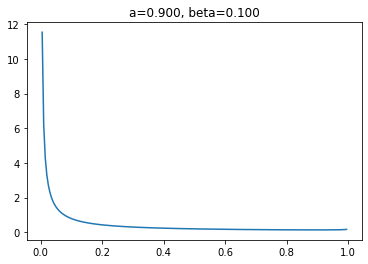

In [56]:
# MODEL
d_in = mus.shape[1]
d_hid = 32
d_out = 4
n_hid = 5
batch_norm = True

# BARLOW LOSS
w_off = 41                  # used with mean
lmbda = calc_lambda(d_out)  # used with sum
eps = 1e-8

# BETA LOSS
a_true, b_true = torch.Tensor([0.1, 0.9])
dist_true = Beta(a_true, b_true)

# LOSS
w_beta   = 1
w_barlow = 1

# TRAIN SPEC
batch_size = 512
num_steps = 500
num_epochs = 20
plot_freq = 10
#
print("LAMBDA: {:.4f}".format(lmbda))
#

plot_beta_pdf(dist_true, "True")

### Test Pipleline

LR(X) 0.983
LR(Z) 0.298


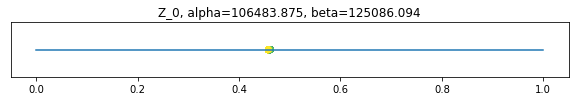

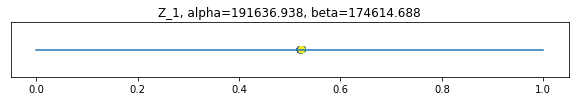

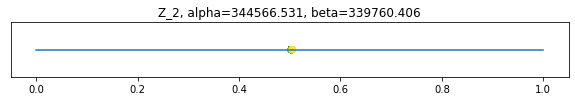

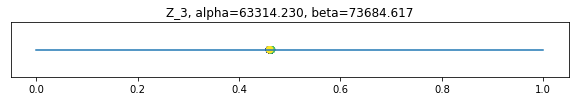

In [57]:
x_train, y_train = dist_in.sample(1000)
x_valid, y_valid = dist_in.sample(1000)
#
x_train = normalizer(x_train)
x_valid = normalizer(x_valid)
#
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print("LR(X)",clf.score(x_valid, y_valid))
#
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
model.eval()
with torch.no_grad():
    z_train = model(x_train)
    z_valid = model(x_valid)

clf = LogisticRegression(random_state=0).fit(z_train, y_train)
print("LR(Z)",clf.score(z_valid, y_valid))
#
a_z, b_z = beta_params(z_train)
for idx in range(d_out):
    title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
    simplex_plot(z_train[:,idx].detach().numpy(), title=title, c=y_train)

### Train

In [60]:
def beta_normalize(x, beta_mean, beta_std):
    return (x - beta_mean) / beta_std

[  1/ 20]:██████████500/500, L=9.5, on=1.63, off=0.149, dkl=5.83, a_min=1, a_max=4.41, b_min=2.69, b_max=23.6     
[  2/ 20]:██████████500/500, L=4.05, on=0.311, off=0.00657, dkl=3.65, a_min=0.427, a_max=1.06, b_min=2.07, b_max=3
[  3/ 20]:██████████500/500, L=3.03, on=0.0641, off=0.00464, dkl=2.9, a_min=0.309, a_max=0.844, b_min=1.58, b_max=
[  4/ 20]:██████████500/500, L=2.74, on=0.0619, off=0.0041, dkl=2.63, a_min=0.258, a_max=0.744, b_min=1.39, b_max=
[  5/ 20]:██████████500/500, L=2.47, on=0.0272, off=0.00291, dkl=2.4, a_min=0.223, a_max=0.704, b_min=1.23, b_max=
[  6/ 20]:██████████500/500, L=2.18, on=0.0379, off=0.00283, dkl=2.1, a_min=0.186, a_max=0.643, b_min=1.08, b_max=
[  7/ 20]:██████████500/500, L=2.23, on=0.0921, off=0.0264, dkl=1.78, a_min=0.167, a_max=0.592, b_min=1.03, b_max=
[  8/ 20]:██████████500/500, L=1.52, on=0.0281, off=0.00304, dkl=1.45, a_min=0.146, a_max=0.518, b_min=0.924, b_ma
[  9/ 20]:██████████500/500, L=1.39, on=0.0992, off=0.00529, dkl=1.21, a_min=0.1

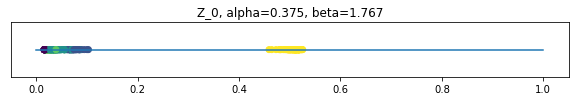

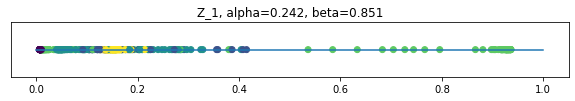

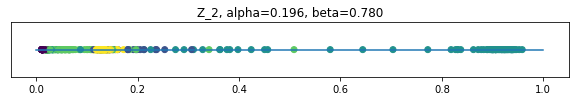

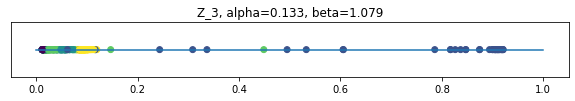

   LINPROB: 0.850


[ 11/ 20]:██████████500/500, L=1.19, on=0.18, off=0.0153, dkl=0.8, a_min=0.125, a_max=0.266, b_min=0.817, b_max=1.
[ 12/ 20]:██████████500/500, L=0.998, on=0.194, off=0.0203, dkl=0.526, a_min=0.11, a_max=0.243, b_min=0.776, b_max
[ 13/ 20]:██████████500/500, L=0.7, on=0.0456, off=0.0169, dkl=0.424, a_min=0.109, a_max=0.194, b_min=0.575, b_max
[ 14/ 20]:██████████500/500, L=0.475, on=0.0935, off=0.00239, dkl=0.348, a_min=0.0968, a_max=0.184, b_min=0.568, b
[ 15/ 20]:██████████500/500, L=0.612, on=0.00583, off=0.0134, dkl=0.424, a_min=0.104, a_max=0.204, b_min=0.561, b_
[ 16/ 20]:██████████500/500, L=0.58, on=0.17, off=0.00586, dkl=0.33, a_min=0.114, a_max=0.173, b_min=0.618, b_max=
[ 17/ 20]:██████████500/500, L=0.523, on=0.0899, off=0.00759, dkl=0.329, a_min=0.0997, a_max=0.17, b_min=0.557, b_
[ 18/ 20]:██████████500/500, L=0.519, on=0.0818, off=0.00514, dkl=0.367, a_min=0.0971, a_max=0.167, b_min=0.529, b
[ 19/ 20]:██████████500/500, L=0.48, on=0.112, off=0.00104, dkl=0.354, a_min=0.1

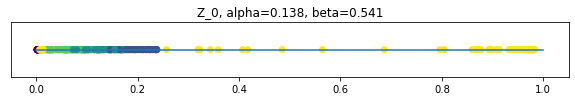

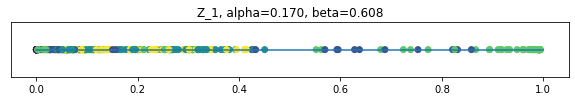

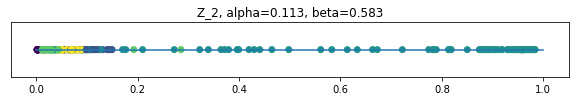

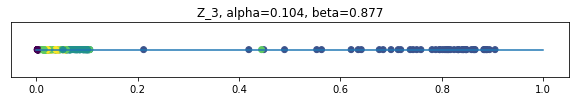

   LINPROB: 0.720


In [118]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    # ##########
    # TRAIN
    # ##########
    model.train()
    desc = "[{:3}/{:3}]".format(epoch_idx, num_epochs)
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{n_fmt}/{total_fmt}{postfix}')
    epoch_loss = 0
    for step in pbar:
        (x1, x2), _ = dist_in.sample_barlow(batch_size)
        x1 = normalizer(x1)
        x2 = normalizer(x2)
        for param in model.parameters():
            param.grad = None
        z1 = model(x1)
        z2 = model(x2)
        
        # BETA LOSS
        a_z, b_z = beta_params(torch.cat([z1, z2], axis=0))
        loss_beta = kl_beta_beta((a_z,b_z),(a_true,b_true),forward=True).sum()
        
        # BARLOW LOSS
        z1_norm = beta_normalize(z1, dist_true.mean, dist_true.stddev)
        z2_norm = beta_normalize(z2, dist_true.mean, dist_true.stddev)
        #
        c = z1_norm.T @ z2_norm
        c.div_(z1.shape[0])
        
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss_barlow = on_diag + lmbda * off_diag
        
        # LOSS
        loss = w_barlow * loss_barlow + w_beta * loss_beta
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        pbar.set_postfix(
              {'L': loss.item(),
               'on': on_diag.item(),
               'off': off_diag.item(),
               'dkl': loss_beta.item(),
               'a_min': a_z.min().item(),
               'a_max': a_z.max().item(),
               'b_min': b_z.min().item(),
               'b_max': b_z.max().item()
               }
          )

    all_loss.append(epoch_loss / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x, y = dist_in.sample(batch_size)
            x = normalizer(x)
            z = model(x)
            a_z, b_z = beta_params(z)
            #
            for idx in range(d_out):
                title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
                simplex_plot(z[:,idx].detach().numpy(), title=title, c=y)
            
            x_train,y_train = dist_in.sample(1000)
            x_valid, y_valid = dist_in.sample(100)
            #
            x_train = normalizer(x_train)
            x_valid = normalizer(x_valid)
            #
            z_train = model(x_train)
            z_valid = model(x_valid)
            #
            clf = LogisticRegression(random_state=0).fit(z_train, y_train)
            print("   LINPROB: {:.3f}".format(clf.score(z_valid, y_valid)))

In [112]:
from tqdm import tqdm

In [117]:
gh = 100
desc = "[{:3}/{:3}]".format(epoch_idx, num_epochs)
pbar = tqdm(range(gh), bar_format=desc +
            '|{bar:5}|{n_fmt}/{total_fmt}{postfix}',
            #"{l_bar}{bar:10}{r_bar}{bar:-10b}"
            dynamic_ncols=True,
           )
for _ in pbar:
  time.sleep(0.01)
  pbar.set_postfix(
      {'L': loss.item(),
       'on': on_diag.item(),
       'off': off_diag.item(),
       'dkl': loss_beta.item(),
       'a_min': a_z.min().item(),
       'a_max': a_z.max().item(),
       'b_min': b_z.min().item(),
       'b_max': b_z.max().item()
       }
  )

[  1/ 20]|█████|100/100, L=22.4, on=1.3, off=0.951, dkl=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b_max=43.2


In [93]:
gh = 100
desc = "Epoch [{:3}/{:3}]".format(epoch_idx, num_epochs)
pbar = tqdm(range(gh), bar_format=desc +
            '{bar:5}{n_fmt}/{total_fmt}\n[{postfix}]'
            #"{bar:5}{r_bar}{bar:-10b}"
            #"|{bar:5}{r_bar}{postfix}"
           )
for _ in pbar:
  time.sleep(0.015)
  pbar.set_postfix(
      {'loss': loss.item(),
       'l_on': on_diag.item(),
       'l_off': off_diag.item(),
       'l_beta': loss_beta.item(),
       'a_min': a_z.min().item(),
       'a_max': a_z.max().item(),
       'b_min': b_z.min().item(),
       'b_max': b_z.max().item()
       }, refresh=False
  )
  pbar.update()

Epoch [  1/ 20]     0/100
Epoch [  1/ 20]▎    7/100
Epoch [  1/ 20]█    21/100off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b_
Epoch [  1/ 20]█▉   39/100off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b
Epoch [  1/ 20]██▋  53/100off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b
Epoch [  1/ 20]███▋ 74/100off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b
Epoch [  1/ 20]████▍88/100off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b
Epoch [  1/ 20]     109/?_off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b
Epoch [  1/ 20]     122/?_off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b_
Epoch [  1/ 20]     133/?_off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b_
Epoch [  1/ 20]     143/?_off=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b_
Epoch [  1/ 20]█████100/100ff=0.951, l_beta=8.16, a_min=2.38, a_max=11.6, b_min=7.27, b_
[, loss=22.4, l_on=1.3, l_off=0.951, l_beta=8.16, a_min=2.38, a